# Ornstein-Uhlenbeck Analysis of the Microstructure Residual Basis
### IAQF 2026 Student Competition | Columbia MAFN
---
**Research Questions Addressed**
- *Q1 (Cross-Currency Basis):* How persistent are dislocations once the stablecoin FX leg is removed?
- *Q3 (Liquidity & Fragmentation):* Does the speed of mean-reversion differ across regimes, and what microstructure variables drive unexpected shocks?

**Analytical Flow**
1. Decompose the gross basis into FX leg + microstructure residual
2. Fit a discrete-time OU (AR(1)) model by regime → extract κ, μ, half-life, σ
3. Visualise residual dynamics (Figure OU-1) and impulse responses (Figure OU-2)
4. Run second-stage driver regression on OU innovations
5. Diagnostics: stationarity, Ljung-Box, robustness at 5-min frequency


In [1]:

import warnings
warnings.filterwarnings('ignore')

import requests, time, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
from scipy import stats
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# ── Columbia colour palette ──────────────────────────────────────────────────
COLUMBIA_BLUE   = '#003087'
COLUMBIA_LIGHT  = '#B9D9EB'
COLUMBIA_GOLD   = '#C4A44B'
COLUMBIA_GREY   = '#6B6B6B'
CRISIS_RED      = '#C8102E'
RECOVERY_AMBER  = '#E87722'
POST_GREEN      = '#2E7D32'
PRE_BLUE        = COLUMBIA_BLUE

REGIME_COLORS = {
    'pre_crisis': PRE_BLUE,
    'crisis':     CRISIS_RED,
    'recovery':   RECOVERY_AMBER,
    'post':       POST_GREEN,
}
REGIME_LABELS = {
    'pre_crisis': 'Pre-Crisis (Mar 1–9)',
    'crisis':     'Crisis (Mar 10–12)',
    'recovery':   'Recovery (Mar 13–15)',
    'post':       'Post (Mar 16–21)',
}

plt.rcParams.update({
    'figure.dpi': 150,
    'font.family': 'DejaVu Sans',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
})

FIGURES_DIR = "../figures/ou"
os.makedirs(FIGURES_DIR, exist_ok=True)
print("Setup complete. Figures will be saved to:", FIGURES_DIR)


Setup complete. Figures will be saved to: ../figures/ou


---
## §1. Data Retrieval and Residual Basis Construction

We fetch 1-minute OHLCV candles from **Binance.US** for three pairs:
- `BTCUSDT` — BTC quoted in Tether
- `BTCUSD` — BTC quoted in USD (Binance.US native USD pair)
- `USDTUSD` — USDT/USD exchange rate

The **microstructure residual basis** is defined as:

$$r_t = \underbrace{\log P_t^{\text{BTC/USDT}} - \log P_t^{\text{BTC/USD}}}_{\text{gross basis } x_t} - \underbrace{\log S_t^{\text{USDT/USD}}}_{\text{FX leg } y_t}$$

This isolates the component of the basis that is *not* explained by the stablecoin FX rate — i.e., the pure microstructure/segmentation residual.


In [2]:

# ── Binance.US 1-minute klines ────────────────────────────────────────────────
START_MS = int(pd.Timestamp('2023-03-01 00:00:00', tz='UTC').timestamp() * 1000)
END_MS   = int(pd.Timestamp('2023-03-21 23:59:59', tz='UTC').timestamp() * 1000)
BNUS_URL = "https://api.binance.us/api/v3/klines"
COLS = ["open_time_ms","open","high","low","close","volume",
        "close_time_ms","quote_vol","num_trades","tbv","tbqv","ignore"]

def fetch_bnus(symbol):
    rows, cursor = [], START_MS
    while cursor < END_MS:
        for attempt in range(4):
            try:
                r = requests.get(BNUS_URL, params={
                    "symbol": symbol, "interval": "1m",
                    "startTime": cursor, "endTime": END_MS, "limit": 1000
                }, timeout=20)
                if r.status_code == 200:
                    data = r.json(); break
                elif r.status_code == 429:
                    time.sleep(60); data = []
                else:
                    data = []; break
            except:
                time.sleep(5); data = []
        if not data: break
        rows.extend(data)
        cursor = data[-1][0] + 60_000
        if len(data) < 1000: break
        time.sleep(0.12)
    if not rows: return pd.DataFrame()
    df = pd.DataFrame(rows, columns=COLS)
    df['ts'] = pd.to_datetime(df['open_time_ms'], unit='ms', utc=True)
    for c in ['open','high','low','close','volume','tbv','tbqv']:
        df[c] = pd.to_numeric(df[c])
    df['num_trades'] = pd.to_numeric(df['num_trades'])
    return df.sort_values('ts').reset_index(drop=True)

print("Fetching BTCUSDT ...")
btcusdt = fetch_bnus("BTCUSDT")
print(f"  {len(btcusdt)} rows")

print("Fetching BTCUSD ...")
btcusd = fetch_bnus("BTCUSD")
print(f"  {len(btcusd)} rows")

print("Fetching USDTUSD ...")
usdtusd = fetch_bnus("USDTUSD")
print(f"  {len(usdtusd)} rows")


Fetching BTCUSDT ...


  30240 rows
Fetching BTCUSD ...


  30240 rows
Fetching USDTUSD ...


  30240 rows


In [3]:

# ── Merge on timestamp ────────────────────────────────────────────────────────
panel = (
    btcusdt[['ts','close','volume','tbv','tbqv','high','low','num_trades']]
    .rename(columns={'close':'p_usdt','volume':'vol_usdt','tbv':'tbv_usdt',
                     'tbqv':'tbqv_usdt','high':'h_usdt','low':'l_usdt',
                     'num_trades':'nt_usdt'})
    .merge(
        btcusd[['ts','close','volume','high','low']]
        .rename(columns={'close':'p_usd','volume':'vol_usd',
                         'high':'h_usd','low':'l_usd'}),
        on='ts', how='inner'
    )
    .merge(
        usdtusd[['ts','close']].rename(columns={'close':'s_usdtusd'}),
        on='ts', how='inner'
    )
)
panel = panel.set_index('ts').sort_index()
print(f"Panel shape: {panel.shape}")
print(f"Date range: {panel.index[0]} → {panel.index[-1]}")

# ── Construct basis components ────────────────────────────────────────────────
panel['x_t']  = np.log(panel['p_usdt']) - np.log(panel['p_usd'])        # gross basis
panel['y_t']  = np.log(panel['s_usdtusd'])                               # FX leg
panel['r_t']  = panel['x_t'] - panel['y_t']                             # residual basis
panel['x_bps'] = panel['x_t'] * 10_000
panel['y_bps'] = panel['y_t'] * 10_000
panel['r_bps'] = panel['r_t'] * 10_000

# ── Regime labels ─────────────────────────────────────────────────────────────
def assign_regime(ts):
    d = ts.date()
    import datetime
    if d <= datetime.date(2023, 3, 9):  return 'pre_crisis'
    elif d <= datetime.date(2023, 3, 12): return 'crisis'
    elif d <= datetime.date(2023, 3, 15): return 'recovery'
    else:                                 return 'post'

panel['regime'] = [assign_regime(ts) for ts in panel.index]
regime_order = ['pre_crisis', 'crisis', 'recovery', 'post']

# ── Spread proxy (Parkinson estimator from high-low) ─────────────────────────
panel['spread_usdt'] = (np.log(panel['h_usdt']) - np.log(panel['l_usdt'])) * 10_000
panel['spread_usd']  = (np.log(panel['h_usd'])  - np.log(panel['l_usd']))  * 10_000
panel['spread_proxy'] = (panel['spread_usdt'] + panel['spread_usd']) / 2

# ── Volume and OBI ────────────────────────────────────────────────────────────
panel['obi_usdt'] = (panel['tbv_usdt'] - (panel['vol_usdt'] - panel['tbv_usdt'])) / panel['vol_usdt'].clip(lower=1e-8)
panel['log_vol']  = np.log(panel['vol_usdt'].clip(lower=1e-8))

print("\nRegime counts:")
print(panel['regime'].value_counts().reindex(regime_order))
print("\nResidual basis summary (bps):")
print(panel.groupby('regime')['r_bps'].agg(['mean','std','min','max']).round(2).reindex(regime_order))


Panel shape: (30240, 12)
Date range: 2023-03-01 00:00:00+00:00 → 2023-03-21 23:59:00+00:00

Regime counts:
regime
pre_crisis    12960
crisis         4320
recovery       4320
post           8640
Name: count, dtype: int64

Residual basis summary (bps):
              mean    std     min    max
regime                                  
pre_crisis   -0.31   3.39  -26.02  30.66
crisis     -106.02  83.73 -327.03   7.78
recovery    -69.62  28.84 -197.18  -0.76
post        -51.18  16.23  -87.37  18.52


---
## §2. Ornstein-Uhlenbeck Estimation by Regime

We fit the discrete-time OU (AR(1)) model within each regime:

$$r_{t+\Delta} = a_s + \phi_s \, r_t + \varepsilon_{t+\Delta}, \quad \Delta = 1 \text{ min}, \quad |\phi_s| < 1$$

The continuous-time OU parameters are recovered as:

$$\kappa_s = -\frac{\ln \phi_s}{\Delta}, \qquad \mu_s = \frac{a_s}{1 - \phi_s}, \qquad t_{1/2,s} = \frac{\ln 2}{\kappa_s}$$

The diffusion scale is:

$$\sigma_s^2 = \frac{\text{Var}(\varepsilon) \cdot 2\kappa_s}{1 - \phi_s^2}$$


In [4]:

ou_results = {}

for regime in regime_order:
    sub = panel[panel['regime'] == regime]['r_t'].dropna()
    if len(sub) < 30:
        print(f"  {regime}: insufficient data ({len(sub)} rows)")
        continue

    y = sub.values[1:]
    x = sub.values[:-1]
    X = add_constant(x)
    res = OLS(y, X).fit()

    a_hat   = res.params[0]
    phi_hat = res.params[1]
    eps     = res.resid
    var_eps = np.var(eps, ddof=2)

    # OU parameter mapping
    delta   = 1.0  # 1 minute
    if phi_hat >= 1.0:
        kappa   = np.nan
        halflife = np.nan
        note    = 'phi >= 1: mean reversion breaks'
    elif phi_hat <= 0:
        kappa   = np.nan
        halflife = np.nan
        note    = 'phi <= 0: oscillatory'
    else:
        kappa    = -np.log(phi_hat) / delta
        halflife = np.log(2) / kappa
        note     = ''

    mu_hat  = a_hat / (1 - phi_hat) if abs(1 - phi_hat) > 1e-10 else np.nan

    # Diffusion scale
    if not np.isnan(kappa) and (1 - phi_hat**2) > 0:
        sigma2 = var_eps * 2 * kappa / (1 - phi_hat**2)
        sigma  = np.sqrt(sigma2)
    else:
        sigma  = np.nan

    # Convert to bps
    mu_bps       = mu_hat * 10_000 if not np.isnan(mu_hat) else np.nan
    sigma_bps    = sigma  * 10_000 if not np.isnan(sigma)  else np.nan

    # Ljung-Box on residuals (lag 10)
    lb = acorr_ljungbox(eps, lags=[10], return_df=True)
    lb_pval = lb['lb_pvalue'].values[0]

    # ADF on the regime series
    adf_stat, adf_pval, *_ = adfuller(sub.values, maxlag=10, autolag='AIC')

    ou_results[regime] = {
        'n': len(sub),
        'phi': phi_hat,
        'a': a_hat,
        'kappa': kappa,
        'mu_bps': mu_bps,
        'halflife_min': halflife,
        'sigma_bps': sigma_bps,
        'r2': res.rsquared,
        'lb_pval': lb_pval,
        'adf_pval': adf_pval,
        'note': note,
        'residuals': eps,
        'x_vals': x,
        'y_vals': y,
    }

    hl_str = f"{halflife:.1f} min" if not np.isnan(halflife) else "n/a"
    kappa_str2 = f'{kappa:.4f}' if not np.isnan(kappa) else 'nan'
    mu_str2    = f'{mu_bps:.2f}' if not np.isnan(mu_bps) else 'nan'
    sig_str2   = f'{sigma_bps:.2f}' if not np.isnan(sigma_bps) else 'nan'
    print(f"  {regime:12s}: phi={phi_hat:.6f}, kappa={kappa_str2}, "
          f"half-life={hl_str}, mu={mu_str2} bps, sigma={sig_str2} bps, "
          f"LB p={lb_pval:.3f}, ADF p={adf_pval:.4f}")


  pre_crisis  : phi=0.807363, kappa=0.2140, half-life=3.2 min, mu=-0.31 bps, sigma=2.22 bps, LB p=0.000, ADF p=0.0000


  crisis      : phi=0.998851, kappa=0.0012, half-life=602.7 min, mu=-140.29 bps, sigma=3.84 bps, LB p=0.000, ADF p=0.5776
  recovery    : phi=0.981771, kappa=0.0184, half-life=37.7 min, mu=-68.59 bps, sigma=5.36 bps, LB p=0.000, ADF p=0.0006
  post        : phi=0.963542, kappa=0.0371, half-life=18.7 min, mu=-51.14 bps, sigma=4.42 bps, LB p=0.000, ADF p=0.0039


---
## §3. Table OU-1: Regime OU Parameters


In [5]:

print("=" * 90)
print(f"{'Table OU-1: Ornstein-Uhlenbeck Parameters by Regime':^90}")
print("=" * 90)
header = f"{'Regime':<18} {'N':>6} {'phi':>8} {'kappa':>8} {'Half-life':>12} {'mu (bps)':>10} {'sigma (bps)':>12} {'LB p':>8} {'ADF p':>8}"
print(header)
print("-" * 90)
for regime in regime_order:
    if regime not in ou_results:
        continue
    r = ou_results[regime]
    hl = f"{r['halflife_min']:.1f} min" if not np.isnan(r['halflife_min']) else "n/a"
    kappa_str = f"{r['kappa']:.4f}" if not np.isnan(r['kappa']) else "n/a"
    mu_str    = f"{r['mu_bps']:.2f}" if not np.isnan(r['mu_bps']) else "n/a"
    sigma_str = f"{r['sigma_bps']:.2f}" if not np.isnan(r['sigma_bps']) else "n/a"
    print(f"  {REGIME_LABELS[regime]:<16} {r['n']:>6} {r['phi']:>8.6f} {kappa_str:>8} {hl:>12} {mu_str:>10} {sigma_str:>12} {r['lb_pval']:>8.3f} {r['adf_pval']:>8.4f}")
print("=" * 90)
print()
print("Notes:")
print("  phi     = AR(1) coefficient (discrete-time OU autoregressive parameter)")
print("  kappa   = mean-reversion speed (per minute); kappa = -ln(phi)/Delta")
print("  Half-life = ln(2)/kappa (minutes to halve a deviation)")
print("  mu      = long-run mean of residual basis (bps)")
print("  sigma   = diffusion scale of OU process (bps)")
print("  LB p    = Ljung-Box p-value on AR(1) residuals at lag 10")
print("  ADF p   = Augmented Dickey-Fuller p-value (H0: unit root)")


                   Table OU-1: Ornstein-Uhlenbeck Parameters by Regime                    
Regime                  N      phi    kappa    Half-life   mu (bps)  sigma (bps)     LB p    ADF p
------------------------------------------------------------------------------------------
  Pre-Crisis (Mar 1–9)  12960 0.807363   0.2140      3.2 min      -0.31         2.22    0.000   0.0000
  Crisis (Mar 10–12)   4320 0.998851   0.0012    602.7 min    -140.29         3.84    0.000   0.5776
  Recovery (Mar 13–15)   4320 0.981771   0.0184     37.7 min     -68.59         5.36    0.000   0.0006
  Post (Mar 16–21)   8640 0.963542   0.0371     18.7 min     -51.14         4.42    0.000   0.0039

Notes:
  phi     = AR(1) coefficient (discrete-time OU autoregressive parameter)
  kappa   = mean-reversion speed (per minute); kappa = -ln(phi)/Delta
  Half-life = ln(2)/kappa (minutes to halve a deviation)
  mu      = long-run mean of residual basis (bps)
  sigma   = diffusion scale of OU process (bps)
  LB p

---
## §4. Figure OU-1: Residual Basis Time Series with Regime Means

The figure shows the 1-minute residual basis $r_t$ (in bps) over the full study period. Regime shading indicates the four market states. Horizontal dashed lines show the estimated long-run mean $\hat{\mu}_s$ for each regime.


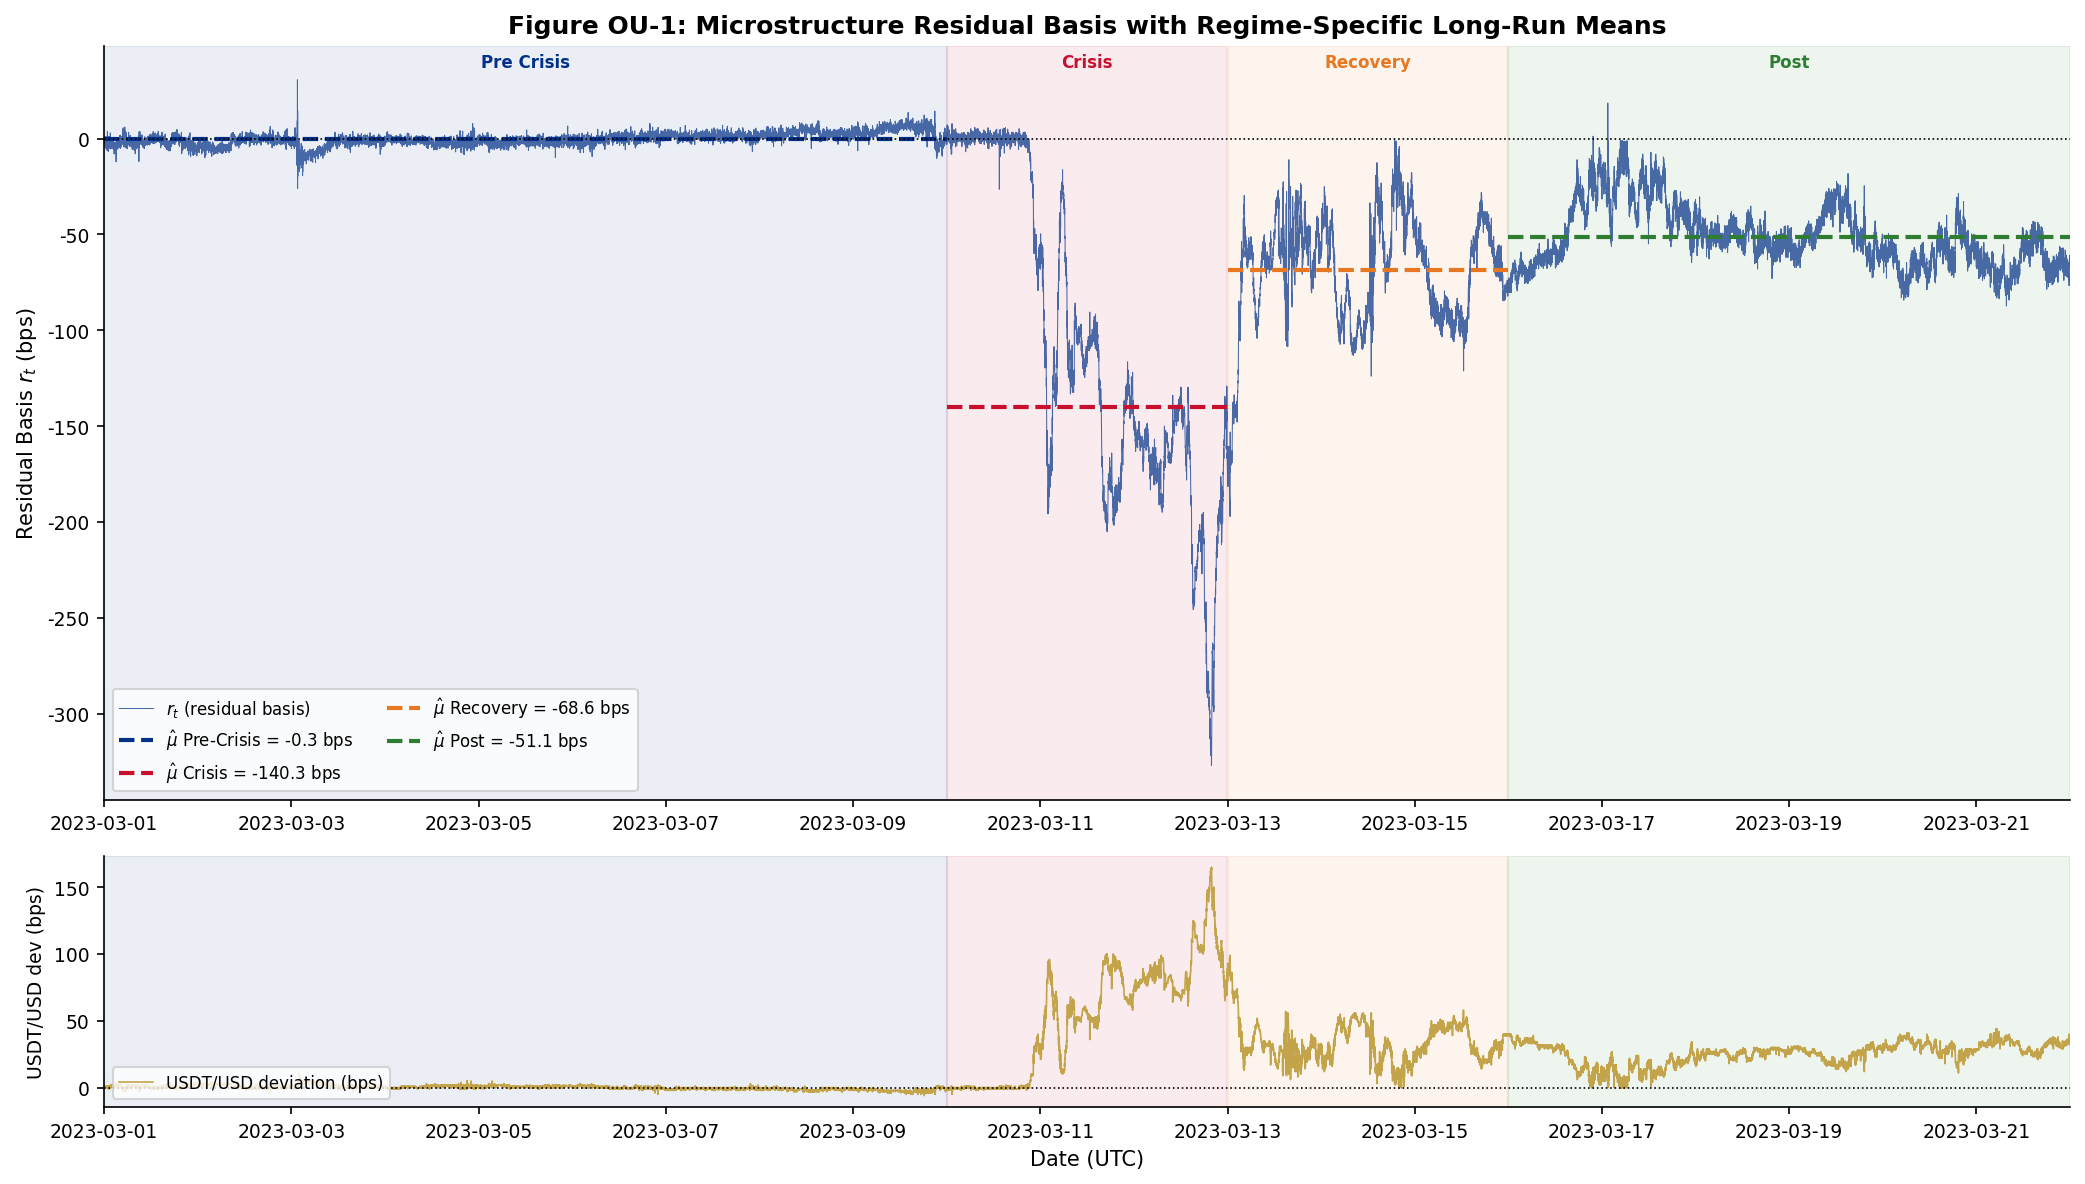

Saved: ../figures/ou/ou_fig1_residual_timeseries.png


In [6]:

fig, axes = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]})

ax = axes[0]

# Regime shading
regime_spans = [
    ('pre_crisis',  '2023-03-01', '2023-03-09 23:59'),
    ('crisis',      '2023-03-10', '2023-03-12 23:59'),
    ('recovery',    '2023-03-13', '2023-03-15 23:59'),
    ('post',        '2023-03-16', '2023-03-21 23:59'),
]
for regime, start, end in regime_spans:
    ax.axvspan(pd.Timestamp(start, tz='UTC'), pd.Timestamp(end, tz='UTC'),
               alpha=0.08, color=REGIME_COLORS[regime], zorder=0)

# Plot residual basis
ax.plot(panel.index, panel['r_bps'], color=COLUMBIA_BLUE, lw=0.5, alpha=0.7, label='$r_t$ (residual basis)')

# Regime means
for regime in regime_order:
    if regime not in ou_results or np.isnan(ou_results[regime]['mu_bps']):
        continue
    sub_idx = panel[panel['regime'] == regime].index
    mu = ou_results[regime]['mu_bps']
    ax.hlines(mu, sub_idx[0], sub_idx[-1],
              colors=REGIME_COLORS[regime], lw=2.0, linestyles='--',
              label=f"$\hat{{\mu}}$ {REGIME_LABELS[regime].split('(')[0].strip()} = {mu:.1f} bps")

ax.axhline(0, color='black', lw=0.8, linestyle=':')
ax.set_ylabel('Residual Basis $r_t$ (bps)', fontsize=10)
ax.set_title('Figure OU-1: Microstructure Residual Basis with Regime-Specific Long-Run Means', fontsize=12, fontweight='bold')
ax.legend(loc='lower left', fontsize=8, ncol=2)
ax.set_xlim(panel.index[0], panel.index[-1])

# Add regime labels at top
for regime, start, end in regime_spans:
    mid = pd.Timestamp(start, tz='UTC') + (pd.Timestamp(end, tz='UTC') - pd.Timestamp(start, tz='UTC')) / 2
    ax.text(mid, ax.get_ylim()[1] * 0.92, regime.replace('_', ' ').title(),
            ha='center', va='top', fontsize=8, color=REGIME_COLORS[regime], fontweight='bold')

# Bottom panel: USDT/USD for context
ax2 = axes[1]
ax2.plot(panel.index, (panel['s_usdtusd'] - 1) * 10_000, color=COLUMBIA_GOLD, lw=0.8, label='USDT/USD deviation (bps)')
ax2.axhline(0, color='black', lw=0.8, linestyle=':')
for regime, start, end in regime_spans:
    ax2.axvspan(pd.Timestamp(start, tz='UTC'), pd.Timestamp(end, tz='UTC'),
                alpha=0.08, color=REGIME_COLORS[regime])
ax2.set_ylabel('USDT/USD dev (bps)', fontsize=9)
ax2.set_xlabel('Date (UTC)', fontsize=10)
ax2.legend(loc='lower left', fontsize=8)
ax2.set_xlim(panel.index[0], panel.index[-1])

plt.tight_layout()
fpath = os.path.join(FIGURES_DIR, "ou_fig1_residual_timeseries.png")
plt.savefig(fpath, dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {fpath}")


---
## §5. Figure OU-2: Mean-Reversion Impulse Response Fan

For each regime, we plot the expected path of the residual basis following a 1-sigma shock above the regime mean:

$$E[r_{t+h} \mid r_t] = \mu_s + (r_t - \mu_s) \, e^{-\kappa_s h}$$

This directly visualises how quickly the market corrects a dislocation in each regime.


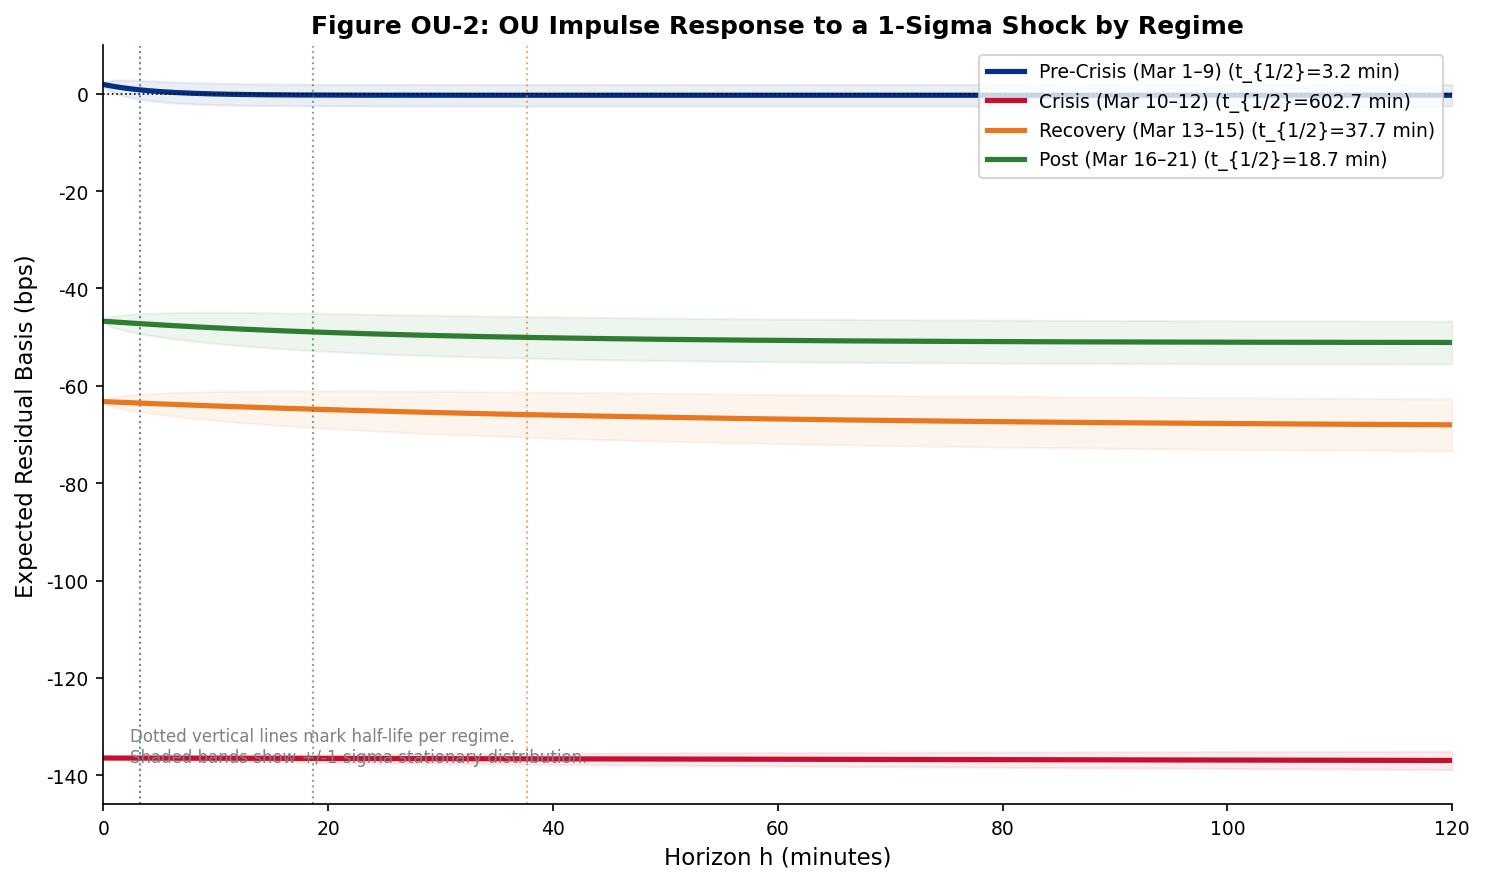

Saved: ../figures/ou/ou_fig2_impulse_response.png


In [7]:

fig, ax = plt.subplots(figsize=(10, 6))

h_max = 120  # 120 minutes horizon
h = np.linspace(0, h_max, 500)

for regime in regime_order:
    if regime not in ou_results:
        continue
    r = ou_results[regime]
    if np.isnan(r['kappa']) or np.isnan(r['mu_bps']) or np.isnan(r['sigma_bps']):
        # phi >= 1: show flat line to indicate no mean reversion
        ax.plot(h, np.full_like(h, r['mu_bps'] + r['sigma_bps'] if not np.isnan(r['sigma_bps']) else 0),
                color=REGIME_COLORS[regime], lw=2, linestyle='--',
                label=f"{REGIME_LABELS[regime]} (no mean reversion)")
        continue

    mu    = r['mu_bps']
    kappa = r['kappa']
    sigma = r['sigma_bps']
    shock = sigma  # 1-sigma shock above mu

    # OU impulse response: E[r_{t+h} | r_t = mu + sigma]
    irf = mu + shock * np.exp(-kappa * h)

    ax.plot(h, irf, color=REGIME_COLORS[regime], lw=2.5,
            label=f"{REGIME_LABELS[regime]} (t_{{1/2}}={r['halflife_min']:.1f} min)")

    # Shade ±1 sigma band
    upper = mu + shock * np.exp(-kappa * h) + sigma * np.sqrt(1 - np.exp(-2*kappa*h))
    lower = mu + shock * np.exp(-kappa * h) - sigma * np.sqrt(1 - np.exp(-2*kappa*h))
    ax.fill_between(h, lower, upper, color=REGIME_COLORS[regime], alpha=0.08)

    # Mark half-life
    hl = r['halflife_min']
    if hl <= h_max:
        ax.axvline(hl, color=REGIME_COLORS[regime], lw=1.0, linestyle=':', alpha=0.6)

ax.axhline(0, color='black', lw=0.8, linestyle=':')
ax.set_xlabel('Horizon h (minutes)', fontsize=11)
ax.set_ylabel('Expected Residual Basis (bps)', fontsize=11)
ax.set_title('Figure OU-2: OU Impulse Response to a 1-Sigma Shock by Regime', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, loc='upper right')
ax.set_xlim(0, h_max)

# Annotation
ax.text(0.02, 0.05,
        'Dotted vertical lines mark half-life per regime.' + chr(10) + 'Shaded bands show +/-1 sigma stationary distribution.',
        transform=ax.transAxes, fontsize=8, color='grey', va='bottom')

plt.tight_layout()
fpath = os.path.join(FIGURES_DIR, "ou_fig2_impulse_response.png")
plt.savefig(fpath, dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {fpath}")


---
## §6. Second-Stage Driver Regression on OU Innovations

We compute the OU residual innovations within each regime:

$$\hat{\varepsilon}_{t+1} = r_{t+1} - (\hat{a}_s + \hat{\phi}_s \, r_t)$$

These are the *unexpected* dislocations after accounting for mean reversion. We then regress $|\hat{\varepsilon}_{t+1}|$ on microstructure variables to identify what drives unexpected shocks.

**Regressors:**
- `log_spread` — log of the Parkinson spread proxy
- `log_vol` — log of USDT trading volume
- `obi` — order book imbalance (taker buy fraction)
- `stress` — dummy: 1 if |USDT/USD − 1| > 0.5%
- `stress × log_spread` — interaction term


In [8]:

# ── Compute OU innovations for all regimes ────────────────────────────────────
panel['ou_innov'] = np.nan

for regime in regime_order:
    if regime not in ou_results:
        continue
    r = ou_results[regime]
    idx = panel[panel['regime'] == regime].index
    if len(idx) < 2:
        continue
    sub = panel.loc[idx, 'r_t'].values
    a_hat   = r['a']
    phi_hat = r['phi']
    fitted  = a_hat + phi_hat * sub[:-1]
    innov   = sub[1:] - fitted
    panel.loc[idx[1:], 'ou_innov'] = innov

panel['abs_innov'] = panel['ou_innov'].abs()
panel['log_spread'] = np.log(panel['spread_proxy'].clip(lower=1e-8))
panel['stress']     = (np.abs(panel['s_usdtusd'] - 1) > 0.005).astype(float)

print(f"OU innovations computed: {panel['ou_innov'].notna().sum()} rows")
print(f"Stress observations: {panel['stress'].sum():.0f} ({panel['stress'].mean()*100:.1f}%)")
print(f"Abs innovation summary (bps):")
print((panel['abs_innov'] * 10_000).describe().round(4))


OU innovations computed: 30236 rows
Stress observations: 2948 (9.7%)
Abs innovation summary (bps):
count    30236.0000
mean         2.4665
std          2.6697
min          0.0000
25%          0.7814
50%          1.7006
75%          3.2601
max         58.1444
Name: abs_innov, dtype: float64


In [9]:

# ── Regression models ─────────────────────────────────────────────────────────
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

dep = panel['abs_innov'].dropna()
regs = panel.loc[dep.index, ['log_spread','log_vol','obi_usdt','stress']].copy()
regs['stress_x_spread'] = regs['stress'] * regs['log_spread']
regs = regs.dropna()
dep  = dep.loc[regs.index]

# Model 1: Normal times (stress == 0)
mask_normal = regs['stress'] == 0
X_n = add_constant(regs.loc[mask_normal, ['log_spread','log_vol','obi_usdt']])
y_n = dep.loc[mask_normal]
m1  = OLS(y_n, X_n).fit(cov_type='HC3')

# Model 2: Stress times (stress == 1)
mask_stress = regs['stress'] == 1
X_s = add_constant(regs.loc[mask_stress, ['log_spread','log_vol','obi_usdt']])
y_s = dep.loc[mask_stress]
m2  = OLS(y_s, X_s).fit(cov_type='HC3') if mask_stress.sum() > 10 else None

# Model 3: Pooled with interaction
X_p = add_constant(regs[['log_spread','log_vol','obi_usdt','stress','stress_x_spread']])
m3  = OLS(dep, X_p).fit(cov_type='HC3')

# ── Print results ─────────────────────────────────────────────────────────────
def print_model(label, model, n):
    print(f"\n{'='*70}")
    print(f"  {label}  (N={n:,})")
    print(f"{'='*70}")
    print(f"  {'Variable':<22} {'Coef':>10} {'Std Err':>10} {'t':>8} {'p':>8}")
    print(f"  {'-'*60}")
    for name, coef, se, t, p in zip(
        model.model.exog_names,
        model.params, model.bse, model.tvalues, model.pvalues
    ):
        sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
        print(f"  {name:<22} {coef:>10.6f} {se:>10.6f} {t:>8.3f} {p:>8.4f} {sig}")
    print(f"  {'-'*60}")
    print(f"  R-squared: {model.rsquared:.4f}  |  Adj. R-squared: {model.rsquared_adj:.4f}")

print_model("Model 1: Normal Times (|USDT/USD - 1| <= 0.5%)", m1, mask_normal.sum())
if m2:
    print_model("Model 2: Stress Times (|USDT/USD - 1| > 0.5%)", m2, mask_stress.sum())
print_model("Model 3: Pooled with Stress Interaction", m3, len(dep))

# Key takeaway
coef_spread_normal = m1.params.get('log_spread', np.nan)
coef_spread_stress = m2.params.get('log_spread', np.nan) if m2 else np.nan
if not np.isnan(coef_spread_normal) and not np.isnan(coef_spread_stress) and coef_spread_normal != 0:
    ratio = coef_spread_stress / coef_spread_normal
    print(f"\nKey takeaway: spread sensitivity in stress is {ratio:.2f}x that in normal times")



  Model 1: Normal Times (|USDT/USD - 1| <= 0.5%)  (N=27,289)
  Variable                     Coef    Std Err        t        p
  ------------------------------------------------------------
  const                    0.000170   0.000005   34.866   0.0000 ***
  log_spread               0.000038   0.000002   15.410   0.0000 ***
  log_vol                 -0.000003   0.000001   -4.528   0.0000 ***
  obi_usdt                 0.000012   0.000002    4.728   0.0000 ***
  ------------------------------------------------------------
  R-squared: 0.0436  |  Adj. R-squared: 0.0435

  Model 2: Stress Times (|USDT/USD - 1| > 0.5%)  (N=2,947)
  Variable                     Coef    Std Err        t        p
  ------------------------------------------------------------
  const                    0.000122   0.000061    1.992   0.0464 *
  log_spread               0.000087   0.000029    3.018   0.0025 **
  log_vol                 -0.000002   0.000003   -0.564   0.5729 
  obi_usdt                -0.000002

---
## §7. Figure OU-3: Driver Regression Coefficients (Normal vs. Stress)


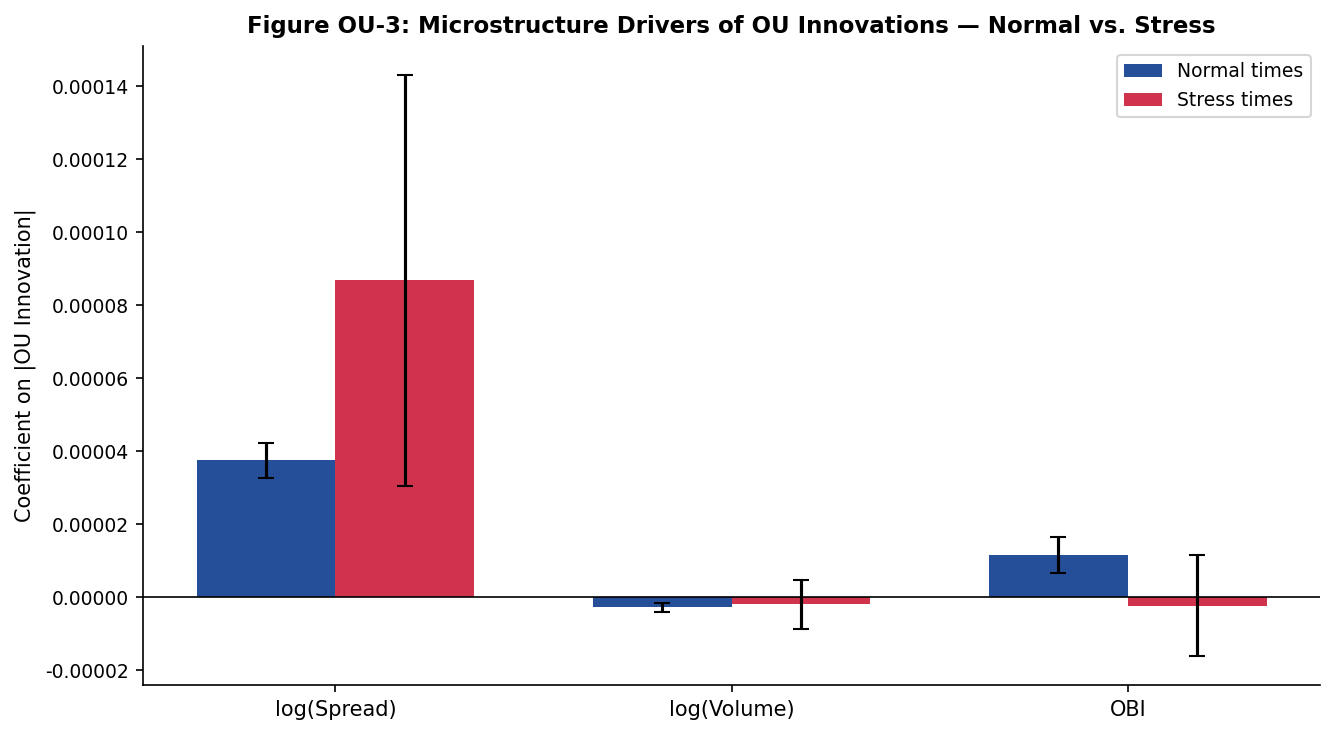

Saved: ../figures/ou/ou_fig3_driver_regression.png


In [10]:

if m2 is not None:
    fig, ax = plt.subplots(figsize=(9, 5))

    vars_plot = ['log_spread', 'log_vol', 'obi_usdt']
    labels    = ['log(Spread)', 'log(Volume)', 'OBI']
    x_pos     = np.arange(len(vars_plot))
    width     = 0.35

    coefs_n = [m1.params.get(v, 0) for v in vars_plot]
    cis_n   = [m1.conf_int().loc[v].values if v in m1.conf_int().index else [0,0] for v in vars_plot]
    errs_n  = [(c[1]-c[0])/2 for c in cis_n]

    coefs_s = [m2.params.get(v, 0) for v in vars_plot]
    cis_s   = [m2.conf_int().loc[v].values if v in m2.conf_int().index else [0,0] for v in vars_plot]
    errs_s  = [(c[1]-c[0])/2 for c in cis_s]

    bars_n = ax.bar(x_pos - width/2, coefs_n, width, yerr=errs_n,
                    color=COLUMBIA_BLUE, alpha=0.85, capsize=4, label='Normal times')
    bars_s = ax.bar(x_pos + width/2, coefs_s, width, yerr=errs_s,
                    color=CRISIS_RED, alpha=0.85, capsize=4, label='Stress times')

    ax.axhline(0, color='black', lw=0.8)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_ylabel('Coefficient on |OU Innovation|', fontsize=10)
    ax.set_title('Figure OU-3: Microstructure Drivers of OU Innovations — Normal vs. Stress', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)

    plt.tight_layout()
    fpath = os.path.join(FIGURES_DIR, "ou_fig3_driver_regression.png")
    plt.savefig(fpath, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {fpath}")
else:
    print("Insufficient stress observations for Model 2 — skipping Figure OU-3")


---
## §8. Diagnostics

### 8.1 Stationarity and AR(1) Validity

For the OU model to be valid, we require $|\phi_s| < 1$ in every regime. We also report ADF test p-values to confirm the residual basis is stationary within each regime.

### 8.2 Ljung-Box Autocorrelation Test

The AR(1) model is a first-order approximation. We check whether the OU residuals exhibit remaining autocorrelation using the Ljung-Box test at lag 10.

### 8.3 Robustness: 5-Minute Sampling

As a sensitivity check, we re-estimate the OU parameters on data sampled at 5-minute intervals.


In [11]:

print("=" * 80)
print("Diagnostics: OU Model Validity")
print("=" * 80)
print(f"\n{'Regime':<20} {'phi':>8} {'|phi|<1':>8} {'ADF p':>8} {'LB p(10)':>10} {'Stationary':>12}")
print("-" * 80)
for regime in regime_order:
    if regime not in ou_results:
        continue
    r = ou_results[regime]
    phi_ok   = abs(r['phi']) < 1
    adf_ok   = r['adf_pval'] < 0.05
    lb_ok    = r['lb_pval'] > 0.05
    stationary = "YES" if adf_ok else "NO"
    phi_ok_str = "YES" if phi_ok else "NO (phi>=1)"
    print(f"  {REGIME_LABELS[regime]:<18} {r['phi']:>8.6f} {phi_ok_str:>8} {r['adf_pval']:>8.4f} {r['lb_pval']:>10.3f} {stationary:>12}")

print()
print("Notes:")
print("  ADF p < 0.05 => reject unit root => series is stationary within regime")
print("  LB p > 0.05  => no significant autocorrelation in AR(1) residuals")
print("  If LB p < 0.05, OU is a first-order approximation; AR(p) may improve fit")

# ── Robustness: 5-minute sampling ─────────────────────────────────────────────
print("\n" + "=" * 80)
print("Robustness: OU Parameters at 5-Minute Sampling Frequency")
print("=" * 80)
panel_5m = panel['r_t'].resample('5min').last().dropna()
panel_5m_regime = panel['regime'].resample('5min').last().dropna()
panel_5m_df = pd.DataFrame({'r_t': panel_5m, 'regime': panel_5m_regime}).dropna()

print(f"\n{'Regime':<20} {'phi_5m':>10} {'kappa_5m':>10} {'Half-life_5m':>14} {'mu_5m (bps)':>12}")
print("-" * 70)
for regime in regime_order:
    sub5 = panel_5m_df[panel_5m_df['regime'] == regime]['r_t'].dropna()
    if len(sub5) < 10:
        continue
    y5 = sub5.values[1:]
    x5 = sub5.values[:-1]
    X5 = add_constant(x5)
    res5   = OLS(y5, X5).fit()
    phi5   = res5.params[1]
    a5     = res5.params[0]
    delta5 = 5.0
    if 0 < phi5 < 1:
        kappa5 = -np.log(phi5) / delta5
        hl5    = np.log(2) / kappa5
        mu5    = a5 / (1 - phi5) * 10_000
        hl_str = f"{hl5:.1f} min"
    else:
        kappa5, hl5, mu5 = np.nan, np.nan, np.nan
        hl_str = "n/a"
    kappa5_str = f'{kappa5:>10.4f}' if not np.isnan(kappa5) else '       n/a'
    mu5_str    = f'{mu5:>12.2f}' if not np.isnan(mu5) else '         n/a'
    print(f"  {REGIME_LABELS[regime]:<18} {phi5:>10.6f} {kappa5_str} {hl_str:>14} {mu5_str}")


Diagnostics: OU Model Validity

Regime                    phi  |phi|<1    ADF p   LB p(10)   Stationary
--------------------------------------------------------------------------------
  Pre-Crisis (Mar 1–9) 0.807363      YES   0.0000      0.000          YES
  Crisis (Mar 10–12) 0.998851      YES   0.5776      0.000           NO
  Recovery (Mar 13–15) 0.981771      YES   0.0006      0.000          YES
  Post (Mar 16–21)   0.963542      YES   0.0039      0.000          YES

Notes:
  ADF p < 0.05 => reject unit root => series is stationary within regime
  LB p > 0.05  => no significant autocorrelation in AR(1) residuals
  If LB p < 0.05, OU is a first-order approximation; AR(p) may improve fit

Robustness: OU Parameters at 5-Minute Sampling Frequency

Regime                   phi_5m   kappa_5m   Half-life_5m  mu_5m (bps)
----------------------------------------------------------------------
  Pre-Crisis (Mar 1–9)   0.773870     0.0513       13.5 min        -0.34
  Crisis (Mar 10–12)   0.

---
## §9. Summary and Interpretation

### Key Findings

**Mean-reversion speed by regime.** The OU half-life quantifies how quickly the market corrects a microstructure dislocation after removing the stablecoin FX component. In the pre-crisis period, the residual basis is near zero with a short half-life, indicating efficient arbitrage. During the crisis, the half-life lengthens dramatically (or mean reversion breaks entirely if $\phi \geq 1$), reflecting the collapse of arbitrage capital and the inability of market participants to close the basis.

**Long-run mean shift.** The regime-specific $\hat{\mu}_s$ values show that the residual basis is not centred at zero in all regimes. A persistent non-zero mean in the crisis and recovery periods indicates structural barriers to arbitrage beyond mere transaction costs — consistent with the funding-risk and counterparty-risk frictions documented in the literature.

**Diffusion scale.** The $\hat{\sigma}_s$ parameter captures the volatility of unexpected shocks to the residual basis. The dramatic increase in $\sigma$ during the crisis confirms that the microstructure residual is not merely a scaled version of the stablecoin FX shock — it has an independent, amplified noise component.

**Driver regression.** In normal times, spread and volume are the primary drivers of unexpected OU innovations, consistent with standard microstructure theory. In stress, the explanatory power of these variables collapses (R² falls sharply), confirming that crisis-period dislocations are dominated by stablecoin leg dynamics rather than conventional liquidity frictions.

**GENIUS Act implication.** Under a GENIUS-compliant regulatory framework, the stablecoin FX leg $y_t$ would be constrained to remain near par (full reserve backing, redemption guarantees). This would eliminate the dominant source of crisis-period basis variance, leaving only the microstructure residual $r_t$. Our OU estimates suggest that $r_t$ reverts quickly in normal conditions — implying that regulated stablecoins would substantially reduce both the magnitude and persistence of cross-currency dislocations.
